<a href="https://colab.research.google.com/github/carloslme/handson-ml2-book/blob/main/06_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Introduction
*Decision Trees* are versatile Machine Learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets. 

Decision Trees are also the fundamental components of Random Forests, which are among the most powerful Machine Learning algorithms available today.

# Training and Visualizing a Decision Tree
Let's build one Decision Tree and take a look at how it makes predictions.

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # petal length and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

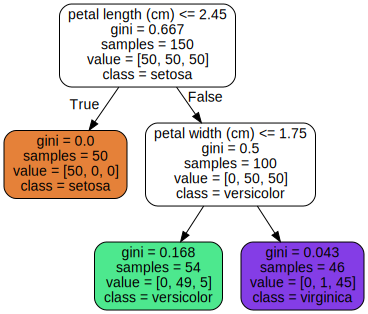

In [3]:
from graphviz import Source
from sklearn.tree import export_graphviz
import os

export_graphviz(
        tree_clf,
        out_file=os.path.join(IMAGES_PATH, "iris_tree.dot"),
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Source.from_file(os.path.join(IMAGES_PATH, "iris_tree.dot"))

# Making Predictions
You start at the *root node* (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a *leaf node* (i.e., it does not have any child nodes), so it does not ask any questions: simply look at the predicted class for that node, and the Decision Tree predicts that your flower is an *Iris setosa* ( `class=setosa `).

Now suppose you find another flower, and this time the petal length is greater than 2.45 cm. You must move down to the root’s right child node (depth 1, right), which is not a leaf node, so the node asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an *Iris versicolor* (depth 2, left). If not, it is likely an *Iris virginica* (depth 2, right). It’s really that simple.

**Note**

One of the many qualities of Decision Trees is that they require very little data preparation. In fact, **they don’t require feature scaling or centering at all.** 

A node’s `samples` attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s `value` attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 *Iris setosa* , 1 `Iris versicolor` , and 45 `Iris virginica `. Finally, a node’s gini attribute measures its *impurity* : a node is “pure” ( `gini=0` ) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to *Iris setosa* training instances, it is pure and its `gini` score is 0. Equation 6-1 shows how the training algorithm computes the `gini` score G i of the i th node. The depth-2 left node has a `gini` score equal to 1 – (0/54) 2 – (49/54) 2 – (5/54) 2 ≈ 0.168.

***Equation. Gini impurity***

$G(i) = 1 - ∑ (k=1, n) (p_{i,k})^2$

Where:

* $p_{i,k}$ is the radio of class $k$ instances among the training instances in the $i^{th}$ node.

**Note**

Scikit-Learn uses the CART algorithm, which produces only *binary trees*: nonleaf nodes always have two children (i.e., questions only have yes/no answers).
However, other algorithms such as ID3 can produce Decision Trees with nodes that have more than two children.

Let's plot the Decision Tree's decision boundaries. 

Saving figure decision_tree_decision_boundaries_plot


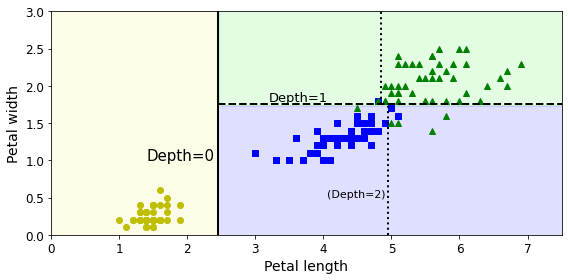

In [4]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.40, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(4.05, 0.5, "(Depth=2)", fontsize=11)

save_fig("decision_tree_decision_boundaries_plot")
plt.show()

The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the lefthand area is pure (only *Iris setosa*), it cannot be split any further. However, the righthand area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line). Since `max_depth` was set to 2, the Decision Tree stops right there. If you set max_depth to 3, then the two depth-2 nodes would each add another decision boundary (represented by the dotted lines).

## Model Interpretation: White Box Versus Black Box
Decision Trees are intuitive, and their decisions are easy to interpret. Such models are often called *white box models*. In contrast, as we will see, Random Forests or neural networks are generally considered *black box models*. They make great predictions, and you can easily check the calculations that they performed to make these predictions; nevertheless, it is usually hard to explain in simple terms why the predictions were made. For example, if a neural network says that a particular person appears on a picture, it is hard to know what contributed to this prediction: did the model recognize that person’s eyes? Their mouth? Their nose? Their shoes? Or even the couch that they were sitting on? Conversely, Decision Trees provide nice, simple classification rules that can even be applied manually if need be (e.g., for flower classification).

# Estimating Class Probabilities
A Decision Tree can also estimate the probability that an instance belongs to a particular class $k$. 
First it find the leaf node for the instance, and then it returns the ratio of training instances of class $k$ in this node and the highest probability.

In [5]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [6]:
tree_clf.predict([[5, 1.5]])

array([1])